# CAS AML Thesis

https://www.kaggle.com/code/mrsohelranapro/car-object-detection-yolov-x-models


https://www.kaggle.com/code/maxkav/yolov5-tutorial-train-with-custom-data

https://stackoverflow.com/questions/74516330/why-am-i-getting-assertionerror-train-no-labels-found-in-content-dataset-test


In [1]:
from IPython.display import HTML, display, Image

# set path containing data folder or use default for Colab (/gdrive/My Drive)
local_folder = "../"


import urllib.request
urllib.request.urlretrieve('https://raw.githubusercontent.com/guiwitz/MLCV/main/notebooks/check_colab.py', 'check_colab.py')
from check_colab import set_datapath
colab, datapath = set_datapath(local_folder)

print('test')

Mounted at /gdrive
test


In [ ]:
path_main = '/gdrive/My Drive/Colab Notebooks/Thesis';
path_yoloset = f'{path_main}/YoloDataset'

In [ ]:
PROJECT_NAME = "yolov5_train"
BASE_MODEL = "yolov5m6.pt"
TRAIN_BATCH = 32
TRAIN_EPOCHS = 100
VAL_BATCH = 64


In [ ]:
! git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 15976, done.
remote: Counting objects: 100% (145/145), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 15976 (delta 88), reused 116 (delta 75), pack-reused 15831
Receiving objects: 100% (15976/15976), 14.61 MiB | 3.57 MiB/s, done.
Resolving deltas: 100% (10957/10957), done.


In [ ]:
! pip install -qr yolov5/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 595.4/595.4 kB 61.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.2 MB/s eta 0:00:00


In [ ]:
import os
import  time, random
import pandas as pd

import torch

from IPython import display
from IPython.display import clear_output
from pathlib import Path
import yaml
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import io
import os
import cv2
import json

import shutil
from tqdm.auto import tqdm

import numpy as np
from sklearn.model_selection import train_test_split

from IPython.display import Image, clear_output

from yolov5 import utils
%matplotlib inline



In [ ]:
img_h, img_w, num_channels = (380, 676, 3)

df = pd.read_csv(f'{path_yoloset}/train_solution_bounding_boxes (1).csv')

df.rename(columns={'image':'image_id'}, inplace=True)
df['image_id'] = df['image_id'].apply(lambda x: x.split('.')[0])
df['x_center'] = (df['xmin'] + df['xmax'])/2
df['y_center'] = (df['ymin'] + df['ymax'])/2
df['w'] = df['xmax'] - df['xmin']
df['h'] = df['ymax'] - df['ymin']
df['classes'] = 0
df['x_center'] = df['x_center']/img_w
df['w'] = df['w']/img_w
df['y_center'] = df['y_center']/img_h
df['h'] = df['h']/img_h
df.head()




,image_id,xmin,ymin,xmax,ymax,x_center,y_center,w,h,classes
0,vid_4_1000,281.259045,187.035071,327.727931,223.225547,0.450434,0.539817,0.068741,0.095238,0
1,vid_4_10000,15.163531,187.035071,120.329957,236.430180,0.100217,0.557191,0.155572,0.129987,0
2,vid_4_10040,239.192475,176.764801,361.968162,236.430180,0.444645,0.543678,0.181621,0.157014,0
3,vid_4_10020,496.483358,172.363256,630.020260,231.539575,0.833213,0.531451,0.197540,0.155727,0
4,vid_4_10060,16.630970,186.546010,132.558611,238.386422,0.110347,0.559122,0.171491,0.136422,0


In [ ]:
index = list(set(df.image_id))
image = random.choice(index)
print("Image ID: %s"%(image))

img = cv2.imread(f'{path_yoloset}/training_images/{image}.jpg')
img.shape

Image ID: vid_4_18340


(380, 676, 3)

In [ ]:
source = 'training_images'

for name, mini in tqdm(df.groupby('image_id')):
    if not os.path.exists('/gdrive/My Drive/Colab Notebooks/Thesis/tmp/labels/'):
        os.makedirs('/gdrive/My Drive/Colab Notebooks/Thesis/tmp/labels/')

    with open('/gdrive/My Drive/Colab Notebooks/Thesis/tmp/labels/{}.txt'.format(name), 'w+') as f:
        row = mini[['classes', 'x_center', 'y_center', 'w', 'h']].astype(float).values
        row = row.astype(str)
        for j in range(len(row)):
            text = ' '.join(row[j])
            f.write(text)
            f.write("\n")

    if not os.path.exists('/gdrive/My Drive/Colab Notebooks/Thesis/tmp/images/'):
        os.makedirs('/gdrive/My Drive/Colab Notebooks/Thesis/tmp/images/')

    shutil.copy(
        '/gdrive/My Drive/Colab Notebooks/Thesis/YoloDataset/{}/{}.jpg'.format(source, name),
        '/gdrive/My Drive/Colab Notebooks/Thesis/tmp/images/{}.jpg'.format(name)
    )



  0%|          | 0/355 [00:00<?, ?it/s]

In [ ]:


IMAGES_PATH = "/gdrive/My Drive/Colab Notebooks/Thesis/tmp/images/"
LABELS_PATH = "/gdrive/My Drive/Colab Notebooks/Thesis/tmp/labels/"

In [ ]:
os.path.exists(IMAGES_PATH)

True

In [ ]:
# Read labels
labels = os.listdir(LABELS_PATH)


# Split data
train, test = train_test_split(labels, test_size=0.15, shuffle=True)
valid, test = train_test_split(test, test_size=0.2)

print(f"train: {len(train)}; valid: {len(valid)}; test: {len(test)}")

train: 301; valid: 43; test: 11


In [ ]:
os.makedirs(f'{path_main}/test/images')
os.makedirs(f'{path_main}/test/labels')
os.makedirs(f'{path_main}/train/images')
os.makedirs(f'{path_main}/train/labels')
os.makedirs(f'{path_main}/valid/images')
os.makedirs(f'{path_main}/valid/labels')

In [ ]:
# Function to move files to directory
def move_files_to_dir(files, dirname):
    # Create target directories if they don't exist
    os.makedirs(f'{path_main}/{dirname}/images', exist_ok=True)
    os.makedirs(f'{path_main}/{dirname}/labels', exist_ok=True)

    for label_filename in files:
        image_filename = f"{label_filename[:-4]}.jpg"
        shutil.copy(f"{IMAGES_PATH}/{image_filename}", f"{path_main}/{dirname}/images/{image_filename}")
        shutil.copy(f"{LABELS_PATH}/{label_filename}", f"{path_main}/{dirname}/labels/{label_filename}")


# Move splits to folders
move_files_to_dir(train, "train")
move_files_to_dir(test, "test")
move_files_to_dir(valid, "valid")




In [ ]:

images_count_img = len(os.listdir(f'{path_main}/train/images'))
images_count_lab = len(os.listdir(f'{path_main}/train/labels'))
labels_count_img = len(os.listdir(f'{path_main}/test/images'))
labels_count_lab = len(os.listdir(f'{path_main}/test/labels'))
valid_count_img = len(os.listdir(f'{path_main}/valid/images'))
valid_count_lab = len(os.listdir(f'{path_main}/valid/labels'))

print(f"Number of files in {path_main}/train/images: {images_count_img}")
print(f"Number of files in {path_main}/train/labels: {images_count_lab}")
print(f"Number of files in {path_main}/test/images: {labels_count_img}")
print(f"Number of files in {path_main}/test/labels: {labels_count_lab}")
print(f"Number of files in {path_main}/valid/images: {valid_count_img}")
print(f"Number of files in {path_main}/valid/labels: {valid_count_lab}")

Number of files in /gdrive/My Drive/Colab Notebooks/Thesis/train/images: 301
Number of files in /gdrive/My Drive/Colab Notebooks/Thesis/train/labels: 301
Number of files in /gdrive/My Drive/Colab Notebooks/Thesis/test/images: 11
Number of files in /gdrive/My Drive/Colab Notebooks/Thesis/test/labels: 11
Number of files in /gdrive/My Drive/Colab Notebooks/Thesis/valid/images: 43
Number of files in /gdrive/My Drive/Colab Notebooks/Thesis/valid/labels: 43


In [ ]:
train_path = f'{path_main}/train'
test_path = f'{path_main}/test'
valid_path  = f'{path_main}/valid'


In [ ]:
test_path

'/gdrive/My Drive/Colab Notebooks/Thesis/test'

In [ ]:


print(
    f"train: {train_path}\n"
    f"test: {test_path}\n"
    f"val: {valid_path}\n"
    f"nc: {1}\n"
    f"names: HopCar",
)

with open("data.yaml", "w") as file:
    yaml.dump({
        "train": train_path,
        "test": test_path,
        "val": valid_path,
        "nc": 1,
        "names": {0: "HopCar"}
    }, file)

train: /gdrive/My Drive/Colab Notebooks/Thesis/train
test: /gdrive/My Drive/Colab Notebooks/Thesis/test
val: /gdrive/My Drive/Colab Notebooks/Thesis/valid
nc: 1
names: HopCar


In [ ]:
# Delete old results if exists
wildcard = f"{PROJECT_NAME}/feature_extraction*"
! rm -r $wildcard

rm: cannot remove 'yolov5_train/feature_extraction*': No such file or directory


In [ ]:


!python yolov5/train.py --batch $TRAIN_BATCH --epochs $TRAIN_EPOCHS --data "data.yaml" --weights $BASE_MODEL --project $PROJECT_NAME --name 'feature_extraction' --cache --freeze 12



train: weights=yolov5m6.pt, cfg=, data=data.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5_train, name=feature_extraction, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[12], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-178-ga199480 Python-3.10.11 torch-2.0.1+cu118 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0

In [ ]:


# Delete old results
wildcard = f"{PROJECT_NAME}/validation_on_test_data*"
! rm -r $wildcard



rm: cannot remove 'yolov5_train/validation_on_test_data*': No such file or directory


In [ ]:


WEIGHTS_BEST = f"{PROJECT_NAME}/feature_extraction/weights/best.pt"
! python yolov5/val.py --weights $WEIGHTS_BEST --batch $VAL_BATCH --data 'data.yaml' --task test --project $PROJECT_NAME --name 'validation_on_test_data' --augment



val: data=data.yaml, weights=['yolov5_train/feature_extraction/weights/best.pt'], batch_size=64, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=True, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5_train, name=validation_on_test_data, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-178-ga199480 Python-3.10.11 torch-2.0.1+cu118 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)

Fusing layers... 
Model summary: 276 layers, 35248920 parameters, 0 gradients, 48.9 GFLOPs
test: Scanning /gdrive/My Drive/Colab Notebooks/Thesis/test/labels... 11 images, 0 backgrounds, 0 corrupt: 100% 11/11 [00:00<00:00, 451.90it/s]
test: New cache created: /gdrive/My Drive/Colab Notebooks/Thesis/test/labels.cache
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 1/1 [00:00<00:00,  1.17it/s]
                   all         11         19      0.994          

In [ ]:
# Delete old results
wildcard = f"{PROJECT_NAME}/detect_test*"
! rm -r $wildcard

rm: cannot remove 'yolov5_train/detect_test*': No such file or directory


In [ ]:
!python yolov5/detect.py --weights $WEIGHTS_BEST --conf 0.6 --source '/gdrive/My Drive/Colab Notebooks/Thesis/tmp/images' --project $PROJECT_NAME --name 'detect_test' --augment --line=3

detect: weights=['yolov5_train/feature_extraction/weights/best.pt'], source=/gdrive/My Drive/Colab Notebooks/Thesis/tmp/images, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.6, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=True, visualize=False, update=False, project=yolov5_train, name=detect_test, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-178-ga199480 Python-3.10.11 torch-2.0.1+cu118 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)

Fusing layers... 
Model summary: 276 layers, 35248920 parameters, 0 gradients, 48.9 GFLOPs
image 1/355 /gdrive/My Drive/Colab Notebooks/Thesis/tmp/images/vid_4_1000.jpg: 384x640 1 HopCar, 342.8ms
image 2/355 /gdrive/My Drive/Colab Notebooks/Thesis/tmp/images/vid_4_10000.jpg: 384x640 1 HopCar, 31.1ms
image 3/355 /gdrive/My Drive/Colab Notebooks/Thesis/tmp/imag

In [ ]:
os.path.exists('yolov5_train/detect_test')

True

In [ ]:
directory = "yolov5_train/detect_test"
contents = os.listdir(directory)

for item in contents:
    print(item)

vid_4_14400.jpg
vid_4_29940.jpg
vid_4_9860.jpg
vid_4_29500.jpg
vid_4_13920.jpg
vid_4_17540.jpg
vid_4_22740.jpg
vid_4_15040.jpg
vid_4_17640.jpg
vid_4_9220.jpg
vid_4_12340.jpg
vid_4_13840.jpg
vid_4_1780.jpg
vid_4_11900.jpg
vid_4_19760.jpg
vid_4_17620.jpg
vid_4_12180.jpg
vid_4_22660.jpg
vid_4_21560.jpg
vid_4_8260.jpg
vid_4_21580.jpg
vid_4_8580.jpg
vid_4_9300.jpg
vid_4_26420.jpg
vid_4_26300.jpg
vid_4_6400.jpg
vid_4_11260.jpg
vid_4_21180.jpg
vid_4_22560.jpg
vid_4_2420.jpg
vid_4_21640.jpg
vid_4_8640.jpg
vid_4_8320.jpg
vid_4_9560.jpg
vid_4_21620.jpg
vid_4_8300.jpg
vid_4_21540.jpg
vid_4_17600.jpg
vid_4_14460.jpg
vid_4_6260.jpg
vid_4_16660.jpg
vid_4_21200.jpg
vid_4_680.jpg
vid_4_6240.jpg
vid_4_2140.jpg
vid_4_16040.jpg
vid_4_22220.jpg
vid_4_13660.jpg
vid_4_6380.jpg
vid_4_9580.jpg
vid_4_26400.jpg
vid_4_21440.jpg
vid_4_9340.jpg
vid_4_6360.jpg
vid_4_9820.jpg
vid_4_29900.jpg
vid_4_15000.jpg
vid_4_17360.jpg
vid_4_920.jpg
vid_4_16500.jpg
vid_4_1980.jpg
vid_4_4520.jpg
vid_4_13760.jpg
vid_4_22980.jpg
vi

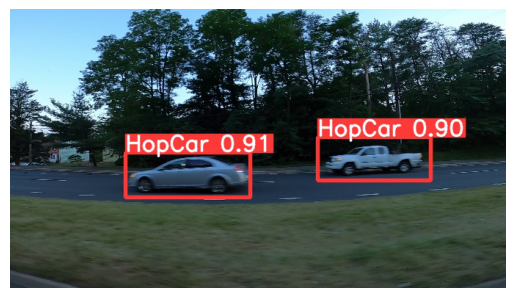

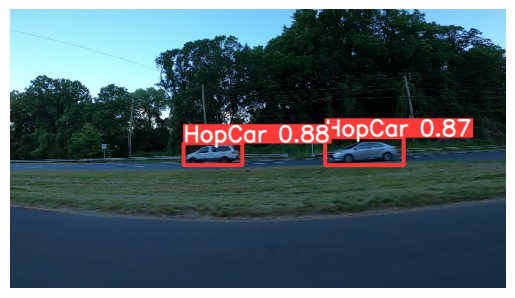

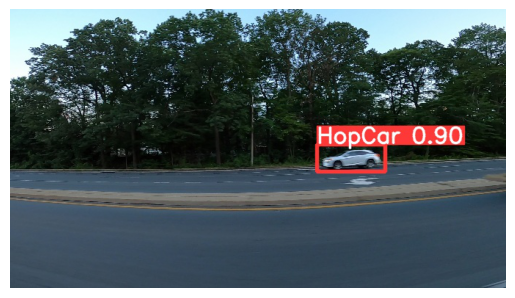

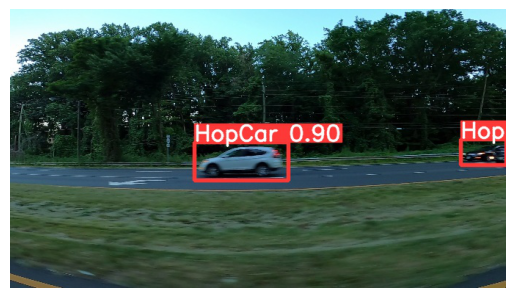

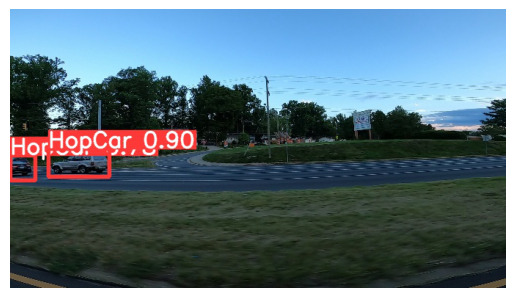

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

directory = "yolov5_train/detect_test"
jpg_files = [file for file in os.listdir(directory) if file.endswith(".jpg")]
random_files = random.sample(jpg_files, 5)

for file in random_files:
    image_path = os.path.join(directory, file)
    image = mpimg.imread(image_path)
    plt.imshow(image)
    plt.axis("off")
    plt.show()